<a href="https://colab.research.google.com/github/alik604/Notebooks/blob/master/Data%20Science-Datasets/MNIST/MNIST_with_denoising_v1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with denoising 

References: 
* the whole damn internet...
* reduce noise: https://blog.keras.io/building-autoencoders-in-keras.html
* reduce noise: https://medium.com/activating-robotic-minds/how-to-reduce-image-noises-by-autoencoder-65d5e6de543
* CNN: https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d
* predict without ANNs: https://github.com/edyoda/data-science-complete-tutorial/blob/master/Case%20Study%20Handwriting%20Detection.ipynb


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import keras
from keras.datasets import *
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D,UpSampling2D

from keras import backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# the data, split between train and test sets
(train_images, train_lables), (test_images, test_lables) = mnist.load_data()
train_images = train_images /255.0
train_lables = train_lables / 255.0


# classnames = ["top", "trouser", "pullover", "dress", "coat",
# "sandal", "shirt", "sneaker", "bag", "ankle boot"]
classnames = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

Using TensorFlow backend.


# Clean Data 

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # when you have to much ram and are too lazy for references...

def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten
X_train = preprocess(X_train)
X_test  = preprocess(X_test)

X_train,X_valid,y_train, y_valid = train_test_split(X_train, y_train,test_size=500)

In [0]:
def make_convolutional_autoencoder():
    # encoding
    inputs = keras.Input(shape=(28, 28, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', 
                        loss='binary_crossentropy')
    return autoencoder
# create a convolutional autoencoder
autoencoder = make_convolutional_autoencoder()

In [0]:
# reshape the flattened images to 28x28 with 1 channel
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)
autoencoder.fit(X_train, X_train, 
                epochs=20, 
                batch_size=128
                #,validation_data=(X_valid, X_valid)
                )

Text(0.5, 1.0, 'original')

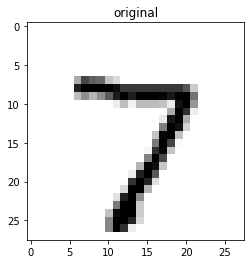

Text(0.5, 1.0, 'decoded')

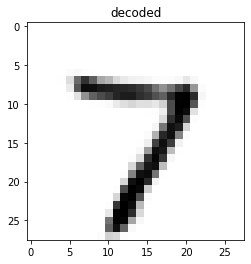

In [5]:
test_base = np.array([X_test[0],X_test[1]])
X_test_decoded = autoencoder.predict(test_base) 

test_input  = test_base.reshape(-1, 28, 28)
test_decoded  = X_test_decoded.reshape(-1, 28, 28)

# # utility to display a row of digits with their predictions
# def display_digits(digits, predictions, labels, title, n):
#   fig = plt.figure(figsize=(13,3))
#   digits = np.reshape(digits, [n, 28, 28])
#   digits = np.swapaxes(digits, 0, 1)
#   digits = np.reshape(digits, [28, 28*n])
#   plt.yticks([])
#   plt.xticks([28*x+14 for x in range(n)], predictions)
#   plt.grid(b=None)
#   for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
#     if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
#   plt.imshow(digits)
#   plt.grid(None)
#   plt.title(title)
#   display.display(fig)

# display_digits(test,None,None,"",len(X_test))


plt.grid(False)
plt.title("original")
plt.imshow(test_input[0],cmap=plt.cm.binary)
plt.show()

plt.title("decoded")
plt.imshow(test_decoded[0],cmap=plt.cm.binary)
plt.show()



## With added noise

In [0]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train)
X_valid_noisy = add_noise(X_valid)
X_test_noisy  = add_noise(X_test)

In [0]:
autoencoder = make_convolutional_autoencoder()
autoencoder.fit(X_train_noisy, X_train, 
                epochs=10, 
                batch_size=128, 
                validation_data=(X_valid_noisy, X_valid))

In [0]:
X_test_decoded = autoencoder.predict(X_test_noisy)

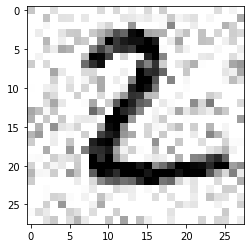

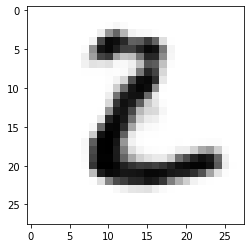

In [9]:
test  = X_test_decoded.reshape(-1, 28, 28)
test_n  = X_test_noisy.reshape(-1, 28, 28)


plt.imshow(test_n[1],cmap=plt.cm.binary)
plt.show()

plt.imshow(test[1],cmap=plt.cm.binary)
plt.show()

# Prediction 

In [0]:
#(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # when you have to much ram and are too lazy for references...

# def preprocess(x):
#     x = x.astype('float32') / 255.
#     return x.reshape(-1, np.prod(x.shape[1:])) # flatten
# X_train = preprocess(X_train)
# X_test  = preprocess(X_test)


# X_test  = X_test.reshape(-1, 28, 28, 1)

X_train_decoded = autoencoder.predict(X_train)
X_test_decoded = autoencoder.predict(X_test) 
X_valid_decoded = autoencoder.predict(X_valid)

In [0]:
X_train = X_train.reshape(-1, 28, 28, 1)

In [71]:
# model = keras.Sequential([
#   keras.layers.Flatten(input_shape=(28,28)),
#   keras.layers.Dense(128,activation="relu"), 
#   keras.layers.Dense(256,activation="relu"),
#   keras.layers.Dense(10,activation="softmax") # adds upto 1             
# ])
# model.compile(optimizer="adam",loss="binary_crossentropy", metrics=["accuracy"])#sparse_categorical_crossentropy
# model.fit(train_images,train_lables,epochs=5)

input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(10,activation=tf.nn.softmax))

model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])#sparse_categorical_crossentropy
model.fit(X_test_decoded,y_test,epochs=5)


Epoch 1/5
10000/10000 [==============================] - 4s 370us/step - loss: 0.6279 - acc: 0.8048
Epoch 2/5
10000/10000 [==============================] - 2s 236us/step - loss: 0.2791 - acc: 0.9144
Epoch 3/5
10000/10000 [==============================] - 2s 240us/step - loss: 0.2270 - acc: 0.9273
Epoch 4/5
10000/10000 [==============================] - 2s 234us/step - loss: 0.1864 - acc: 0.9384
Epoch 5/5
10000/10000 [==============================] - 2s 219us/step - loss: 0.1525 - acc: 0.9476


In [92]:
test_loss,test_acc = model.evaluate(X_valid_noisy,y_valid[:len(X_valid_noisy)]) # TODO need other test set 
print("tested Acc: ", test_acc) # 0.9803; two conv2d = .9891; two conv2d  + Dense 128 + drop 0.2 + Dense 32 = .9896



500/500 [==============================] - 0s 146us/step
tested Acc:  0.9439999995231628


* X_test_decoded on X_valid = .94
* X_test_decoded on X_valid_noisy = .933
* X_test_decoded on X_test_noisy = .956
* X_test_decoded on X_test_decoded = .9676
* X_test_noisy = 0.968
* X_valid on X_test = .84
* X_valid on X_test_decoded = .83
* X_valid on X_test_noisy = .80

In [0]:
prediction = model.predict(X_valid_noisy)
#prediction
for i in range(2):
  plt.grid(False)
  plt.imshow(X_valid_noisy[i].reshape(28,28),cmap=plt.cm.binary)
  plt.xlabel("Actual: " + classnames[y_valid[i]])
  plt.title("Prediction: " + classnames[np.argmax(prediction[i])])
  plt.show()

In [77]:
test_loss,test_acc = model.evaluate(X_test,y_test[:len(X_test_decoded)])
print("tested Acc: ", test_acc) # 0.9803; two conv2d = .9891; two conv2d  + Dense 128 + drop 0.2 + Dense 32 = .9896

10000/10000 [==============================] - 1s 97us/step
tested Acc:  0.9619


In [78]:
test_loss,test_acc = model.evaluate(X_test_noisy,y_test[:len(X_test_noisy)])
print("tested Acc: ", test_acc) # 0.9803; two conv2d = .9891; two conv2d  + Dense 128 + drop 0.2 + Dense 32 = .9896

10000/10000 [==============================] - 1s 90us/step
tested Acc:  0.9519


In [79]:
test_loss,test_acc = model.evaluate(X_test_decoded,y_test[:len(X_test_decoded)])
print("tested Acc: ", test_acc) # 0.9803; two conv2d = .9891; two conv2d  + Dense 128 + drop 0.2 + Dense 32 = .9896

10000/10000 [==============================] - 1s 88us/step
tested Acc:  0.9676


* train
* train noisy
* train decoded 

In [80]:
test_loss,test_acc = model.evaluate(X_train,y_train[:len(X_train)]) #X_train = X_train.reshape(-1, 28, 28, 1)
print("tested Acc: ", test_acc) 

60000/60000 [==============================] - 5s 89us/step
tested Acc:  0.9420166666666666


In [81]:
test_loss,test_acc = model.evaluate(X_train_noisy,y_train)
print("tested Acc: ", test_acc) 

ValueError: ignored

In [82]:
test_loss,test_acc = model.evaluate(X_train_decoded,y_train[:len(X_train_decoded)])
print("tested Acc: ", test_acc) 

59500/59500 [==============================] - 6s 93us/step
tested Acc:  0.10107563025260172


* valid
* valid noisy
* valid decoded

In [83]:
test_loss,test_acc = model.evaluate(X_valid,y_valid[:len(X_valid)])
print("tested Acc: ", test_acc) 

500/500 [==============================] - 0s 106us/step
tested Acc:  0.9439999995231628


In [93]:
test_loss,test_acc = model.evaluate(X_valid_noisy,y_valid)
print("tested Acc: ", test_acc)

500/500 [==============================] - 0s 148us/step
tested Acc:  0.9439999995231628


In [94]:
test_loss,test_acc = model.evaluate(X_valid_decoded,y_valid)
print("tested Acc: ", test_acc) 

500/500 [==============================] - 0s 110us/step
tested Acc:  0.9319999995231628


# Control Test 

In [86]:
#@ model_control

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # when you have to much ram and are too lazy for references...

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255


# model = keras.Sequential([
#   keras.layers.Flatten(input_shape=(28,28)),
#   keras.layers.Dense(128,activation="relu"), 
#   keras.layers.Dense(256,activation="relu"),
#   keras.layers.Dense(10,activation="softmax") # adds upto 1             
# ])
# model.compile(optimizer="adam",loss="binary_crossentropy", metrics=["accuracy"])#sparse_categorical_crossentropy
# model.fit(train_images,train_lables,epochs=5)

input_shape = (28, 28, 1)

model_control = Sequential()
model_control.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model_control.add(MaxPooling2D(pool_size=(2, 2)))
model_control.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model_control.add(MaxPooling2D(pool_size=(2, 2)))
model_control.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model_control.add(Dense(128, activation=tf.nn.relu))
model_control.add(Dropout(0.2))
model_control.add(Dense(32, activation=tf.nn.relu))
model_control.add(Dense(10,activation=tf.nn.softmax))

model_control.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])#sparse_categorical_crossentropy
model_control.fit(x_train,y_train,epochs=5)


test_loss,test_acc = model_control.evaluate(x_test,y_test)
print("tested Acc: ", test_acc) # 0.9803; two conv2d = .9891; two conv2d  + Dense 128 + drop 0.2 + Dense 32 = .9896

Epoch 1/5
60000/60000 [==============================] - 15s 250us/step - loss: 0.1924 - acc: 0.9409
Epoch 2/5
60000/60000 [==============================] - 13s 225us/step - loss: 0.0653 - acc: 0.9797
Epoch 3/5
60000/60000 [==============================] - 14s 236us/step - loss: 0.0498 - acc: 0.9842
Epoch 4/5
60000/60000 [==============================] - 14s 234us/step - loss: 0.0405 - acc: 0.9874
Epoch 5/5
60000/60000 [==============================] - 14s 226us/step - loss: 0.0341 - acc: 0.9888


10000/10000 [==============================] - 1s 139us/step
tested Acc:  0.9884


In [97]:
test_loss,test_acc = model_control.evaluate(X_valid_noisy,y_valid)
print("tested Acc: ", test_acc) 

10000/10000 [==============================] - 1s 96us/step
tested Acc:  0.9671


model_control.evaluate(X_valid_noisy,y_valid) has test acc
.982

while, 

0.9339999990463257

Text(0.5, 0, 'Actual: 7')

Text(0.5, 1.0, 'Prediction: 7')

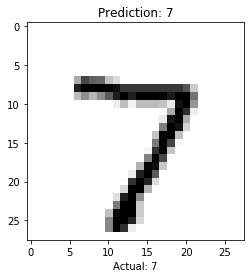

Text(0.5, 0, 'Actual: 2')

Text(0.5, 1.0, 'Prediction: 2')

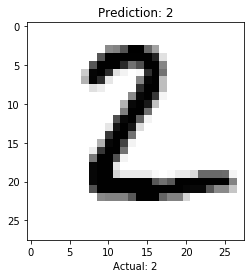

Text(0.5, 0, 'Actual: 1')

Text(0.5, 1.0, 'Prediction: 1')

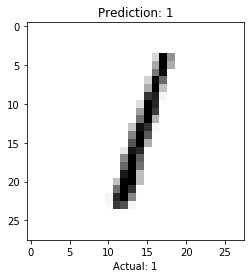

Text(0.5, 0, 'Actual: 0')

Text(0.5, 1.0, 'Prediction: 0')

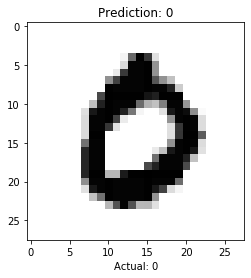

Text(0.5, 0, 'Actual: 4')

Text(0.5, 1.0, 'Prediction: 4')

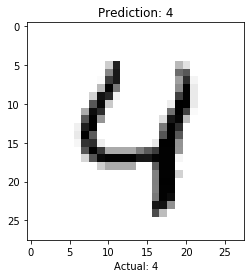

In [96]:
prediction = model_control.predict(x_test)
#prediction
for i in range(5):
  plt.grid(False)
  plt.imshow(x_test[i].reshape(28,28),cmap=plt.cm.binary)
  plt.xlabel("Actual: " + classnames[y_test[i]])
  plt.title("Prediction: " + classnames[np.argmax(prediction[i])])
  plt.show()